In [13]:
%load_ext autoreload
%autoreload 2
from data_utils import load_news_items
import numpy as np
from Simulation import assign_groups, Usersampler, simulate, get_numerical_relevances
from plotting import combine_and_plot_ndcg_unfairness
%matplotlib inline
from config import ex
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
trials = 10

# News Experiment


In [15]:
def trial(items, start_popularity, G, ranking_method, user_generator, iterations=3000, DATA_SET = 0):

    popularity = np.copy(start_popularity)
    # Run Simulation
    
    numerical_relevances = get_numerical_relevances(items,DATA_SET, "")
    iterations, ranking_hist, popularity_hist, final_ranking, users, ideal, mean_relevances, w_pophist, errors, mean_exposure, fairness_hist, p_pophist = \
        simulate(popularity, items, ranking_method=ranking_method, click_model="PBM_log", iterations=iterations, numerical_relevance=numerical_relevances, user_generator=user_generator)
    ranking_hist = ranking_hist.astype(int)

    # Calculate the relevance difference between true relevance and approximation
    # Diff = |rel' - rel|
    if ranking_method == "Naive":
        rel_estimate = popularity_hist / np.arange(1, iterations + 1)[:, np.newaxis]
    elif "Pers" in ranking_method:
        p_pophist[99:, :] = [np.sum(p_pophist[98:100 + i, :], axis=0) for i in range(len(p_pophist) - 99)]
        rel_estimate = p_pophist / (np.arange(iterations) + 1)[:, np.newaxis]
    else:
        rel_estimate = w_pophist / np.arange(1, iterations + 1)[:, np.newaxis]

    rel_diff_trial = np.mean(np.abs(rel_estimate - (mean_relevances)[np.newaxis, :]), axis=1)
    return fairness_hist

def compare_models_news(ranking_methods, iterations = 3000):
    multiple_items = [load_news_items(n=30, completly_random=True) for i in range(trials)]
    items = multiple_items[0]
    popularity = np.ones(len(items))
    G = assign_groups(items)
    user_generator = Usersampler(DATA_SET=0, BI_LEFT=0.5, MOVIE_RATING_FILE = None)
    
    data = {"prop": np.zeros((len(ranking_methods), iterations, len(G))),
                "clicks": np.zeros((len(ranking_methods), iterations, len(G))), "rel": np.zeros((len(ranking_methods), iterations, len(G))),
                "true_rel": np.zeros((len(ranking_methods), iterations, len(G))), "NDCG": np.zeros((len(ranking_methods), iterations))}
      
    
    for i, method in enumerate(ranking_methods):
        data_hist = trial(items, popularity, G, method, user_generator, iterations, DATA_SET=0)
        for key, value in data_hist.items():
            data[key][i] = value

            
    overall_fairness = get_unfairness(data, G)
    
    plot_unfairness_and_NDCG(data["NDCG"], overall_fairness, ranking_methods, G)
    return data, overall_fairness


def get_unfairness(data, G):
    n_methods, iterations = np.shape(data["NDCG"])
    pair_group_combinations = [(a, b) for a in range(len(G)) for b in range(a + 1, len(G))]
    overall_fairness = np.zeros((n_methods, iterations, 4))
    for i in range(n_methods):
        for a, b in pair_group_combinations:
            overall_fairness[i, :, 0] += np.abs(
                data["prop"][i, :, a] / data["rel"][i, :, a] - data["prop"][i, :, b] / data["rel"][i, :, b])
            overall_fairness[i, :, 1] += np.abs(
                data["prop"][i, :, a] / data["true_rel"][i, :, a] - data["prop"][i, :, b] / data["true_rel"][i, :, b])
            overall_fairness[i, :, 2] += np.abs(
                data["clicks"][i, :, a] / data["rel"][i, :, a] - data["clicks"][i, :, b] / data["rel"][i, :, b])
            overall_fairness[i, :, 3] += np.abs(
                data["clicks"][i, :, a] / data["true_rel"][i, :, a] - data["clicks"][i, :, b] / data["true_rel"][i,:,b])
            
    return overall_fairness

def plot_unfairness_and_NDCG(ndcg, overall_fairness, ranking_methods, G):
    #Exposure Unfairness
    combine_and_plot_ndcg_unfairness(np.expand_dims(ndcg,axis=1),np.expand_dims(overall_fairness[:, :, 1],axis=1),labels= ranking_methods, selection=np.arange(len(ranking_methods)), name="JupyterNDCG_UnfairExposure.pdf",type = 0 )
    #Impact Unfairness
    combine_and_plot_ndcg_unfairness(np.expand_dims(ndcg,axis=1),np.expand_dims(overall_fairness[:, :, 3],axis=1),labels= ranking_methods, selection=np.arange(len(ranking_methods)), name="JupyterNDCG_UnfairImpact.pdf",type = 1 )
    
def plot_NDCG(run_data, ranking_methods):
    for i in len(ranking_methods):
        plot_ndcg(run_data["NDCG"][i], label=ranking_methods[i], plot=False, window_size=100)
    plt.legend()
    ax = plt.gca()
    plt.show()
    
    

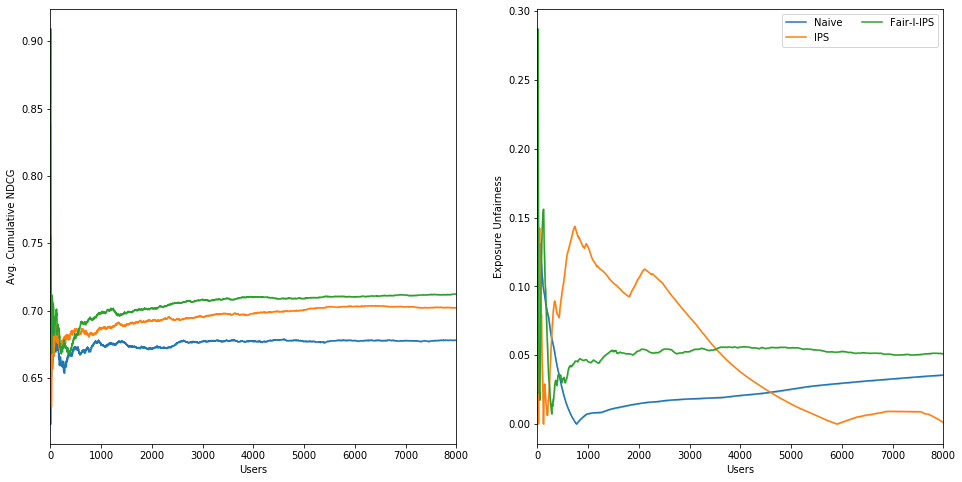

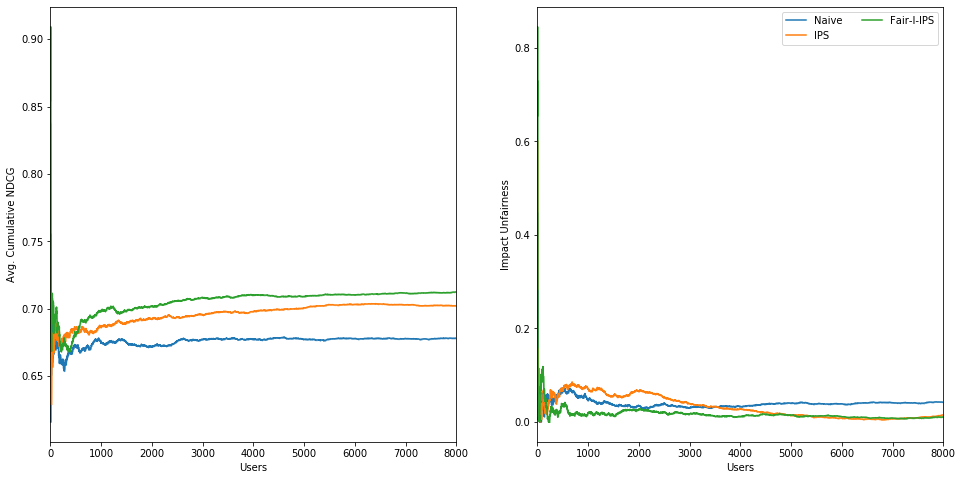

In [20]:
ranking_methods = ["Naive","IPS","Fair-I-IPS", "Fair-E-IPS"]
data, unfairness  = compare_models_news(ranking_methods, iterations = 8000)